IMPORTING REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


LOADING DATASET IN CSV FORMAT

In [2]:
# Load CSV
df = pd.read_csv("household_energy_consumption.csv")

# Convert Date column
df['Date'] = pd.to_datetime(df['Date'])

# Sort correctly (VERY IMPORTANT)
df = df.sort_values(['Household_ID', 'Date'])


In [3]:
df

,Household_ID,Date,Energy_Consumption_kWh,Household_Size,Avg_Temperature_C,Has_AC,Peak_Hours_Usage_kWh
0,H00001,2025-04-01,8.4,4,17.8,No,3.2
1,H00001,2025-04-02,7.9,4,17.3,No,2.8
2,H00001,2025-04-03,9.2,4,18.6,No,3.0
3,H00001,2025-04-04,7.9,4,18.2,No,2.7
4,H00001,2025-04-05,9.6,4,11.9,No,3.2
...,...,...,...,...,...,...,...
89995,H12857,2025-04-04,5.0,2,19.3,No,1.5
89996,H12857,2025-04-05,5.3,2,16.1,No,1.7
89997,H12857,2025-04-06,4.3,2,14.6,No,1.5
89998,H12857,2025-04-07,7.2,2,18.2,No,2.6


FEATURE ENGINEERING( LAG VARIABLES)


In [42]:
df['lag_1'] = df.groupby('Household_ID')['Energy_Consumption_kWh'].shift(1)


In [43]:
df[['lag_1']]

,lag_1
0,NaN
1,8.4
2,7.9
3,9.2
4,7.9
...,...
89995,3.8
89996,5.0
89997,5.3
89998,4.3


ROLLING VARIABLES

In [44]:
df['rolling_3'] = (
    df.groupby('Household_ID')['Energy_Consumption_kWh']
      .rolling(window=3)
      .mean()
      .reset_index(level=0, drop=True)
)


In [45]:
df_model = df.dropna(subset=['lag_1', 'rolling_3']).reset_index(drop=True)

print("Rows after feature engineering:", len(df_model))


Rows after feature engineering: 64286


TO REMOVE MISSING VALUES

In [46]:
df

,Household_ID,Date,Energy_Consumption_kWh,Household_Size,Avg_Temperature_C,Has_AC,Peak_Hours_Usage_kWh,lag_1,lag_7,rolling_3,rolling_7
0,H00001,2025-04-01,8.4,4,17.8,No,3.2,NaN,NaN,NaN,NaN
1,H00001,2025-04-02,7.9,4,17.3,No,2.8,8.4,NaN,NaN,NaN
2,H00001,2025-04-03,9.2,4,18.6,No,3.0,7.9,NaN,8.500000,NaN
3,H00001,2025-04-04,7.9,4,18.2,No,2.7,9.2,NaN,8.333333,NaN
4,H00001,2025-04-05,9.6,4,11.9,No,3.2,7.9,NaN,8.900000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
89995,H12857,2025-04-04,5.0,2,19.3,No,1.5,3.8,NaN,4.200000,NaN
89996,H12857,2025-04-05,5.3,2,16.1,No,1.7,5.0,NaN,4.700000,NaN
89997,H12857,2025-04-06,4.3,2,14.6,No,1.5,5.3,NaN,4.866667,NaN
89998,H12857,2025-04-07,7.2,2,18.2,No,2.6,4.3,NaN,5.600000,4.885714


DEFINING THE FEARURE AND THE TARGETS

In [47]:
X = df_model[
    [
        'lag_1',
        'rolling_3',
        'Household_Size',
        'Avg_Temperature_C',
        'Has_AC',
        'Peak_Hours_Usage_kWh'
    ]
]
y = df_model['Energy_Consumption_kWh']


In [48]:
split_index = int(len(df_model) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


In [50]:
model = LinearRegression()

# Convert 'Has_AC' to numerical using one-hot encoding for X_train and X_test
X_train_encoded = pd.get_dummies(X_train, columns=['Has_AC'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['Has_AC'], drop_first=True)

model.fit(X_train_encoded, y_train)

LinearRegression()

In [52]:
y_pred = model.predict(X_test_encoded)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae, 2))

Mean Absolute Error (MAE): 0.58


In [53]:
household_id = df_model['Household_ID'].iloc[0]
last_row = df_model[df_model['Household_ID'] == household_id].iloc[-1]


In [55]:
future_predictions = []

lag_1 = last_row['Energy_Consumption_kWh']
rolling_3 = last_row['rolling_3']

# Get the feature names the model was trained on
# This includes the one-hot encoded 'Has_AC_Yes'
model_features = X_train_encoded.columns.tolist()

for i in range(7):
    # Prepare 'Has_AC_Yes' value based on 'last_row'
    has_ac_encoded = 1 if last_row['Has_AC'] == 'Yes' else 0

    # Construct the data for the future prediction
    future_data = {
        'lag_1': lag_1,
        'rolling_3': rolling_3,
        'Household_Size': last_row['Household_Size'],
        'Avg_Temperature_C': last_row['Avg_Temperature_C'],
        'Peak_Hours_Usage_kWh': last_row['Peak_Hours_Usage_kWh'],
        'Has_AC_Yes': has_ac_encoded # Use the encoded numerical value
    }

    # Create DataFrame ensuring column order matches model_features
    X_future = pd.DataFrame([future_data], columns=model_features)

    prediction = model.predict(X_future)[0]
    future_predictions.append(prediction)

    # Update lag & rolling values for the next iteration
    lag_1 = prediction
    rolling_3 = (rolling_3 * 2 + prediction) / 3

In [56]:
future_dates = pd.date_range(
    start=df_model['Date'].max() + pd.Timedelta(days=1),
    periods=7
)

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Energy_Consumption_kWh': future_predictions
})

forecast_df.to_csv("7_day_energy_forecast.csv", index=False)

print("7-day forecast saved as: 7_day_energy_forecast.csv")


7-day forecast saved as: 7_day_energy_forecast.csv


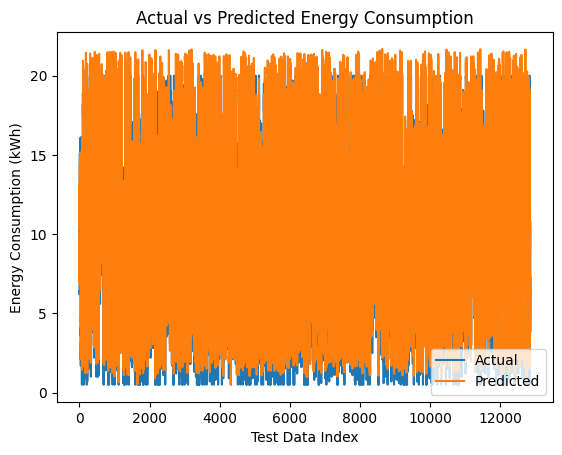

In [57]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Test Data Index')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()


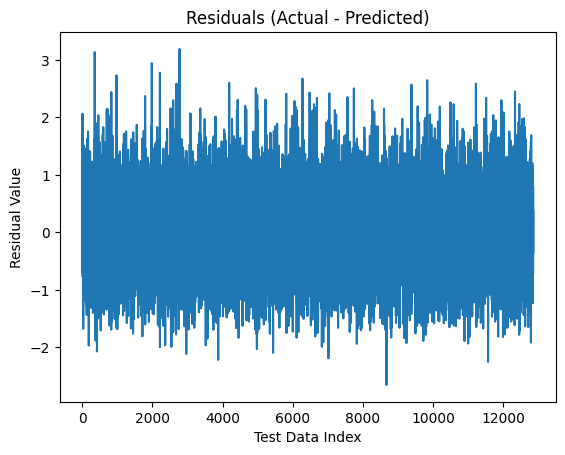

In [58]:
residuals = y_test.values - y_pred

plt.figure()
plt.plot(residuals)
plt.title('Residuals (Actual - Predicted)')
plt.xlabel('Test Data Index')
plt.ylabel('Residual Value')
plt.show()


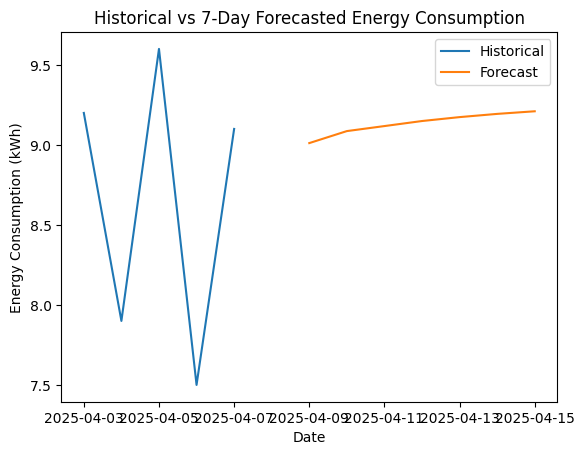

In [59]:
historical = df_model[df_model['Household_ID'] == household_id].tail(30)

plt.figure()
plt.plot(historical['Date'], historical['Energy_Consumption_kWh'], label='Historical')
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Energy_Consumption_kWh'], label='Forecast')
plt.title('Historical vs 7-Day Forecasted Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()


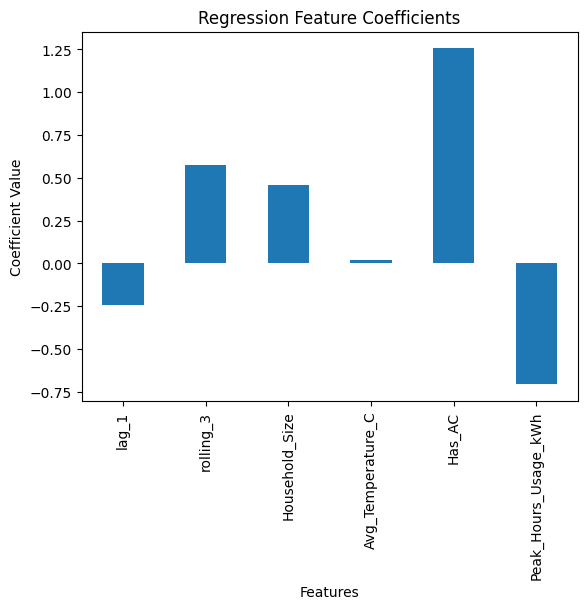

In [60]:
coefficients = pd.Series(
    model.coef_,
    index=X.columns
)

plt.figure()
coefficients.plot(kind='bar')
plt.title('Regression Feature Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()
